In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import pandas as pd

# tf tutorial
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb#scrollTo=Cuym4yvk76vU

In [2]:
mat = loadmat('em_fixed_text_9loc.mat')
labels = mat['label']
traces = mat['traces']

raw_dataset = pd.DataFrame(np.concatenate((np.transpose(labels), traces), axis=1))
dataset = raw_dataset.copy()

In [3]:
# Creat dataset 60/20/20
train_dataset = dataset.sample(frac = 0.8) # random shuffle
test_dataset = dataset.drop(train_dataset.index)

# Seperate lables
train_labels = train_dataset.pop(0)
test_labels = test_dataset.pop(0)
# train_dataset.describe()
# test_dataset.describe()

In [4]:
model = models.Sequential()
model.add(layers.Reshape((5000, 1), input_shape=(5000, )))
model.add(layers.Conv1D(30, 30, activation='relu', input_shape=(5000, 1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(50, 20, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 5000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4971, 30)          930       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1657, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1657, 30)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1638, 50)          30050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 546, 50)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 546, 50)           0

In [6]:
# inputs = keras.Input(shape=(5000,), name='sample_input')
# x = layers.Dense(64, activation='relu')(inputs)
# x = layers.Dense(64, activation='relu')(x)
# outputs = layers.Dense(9, activation='softmax', name='Final')(x)
# model = keras.Model(inputs=inputs, outputs=outputs, name='location')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()
keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [7]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train model
history = model.fit(train_dataset, train_labels, batch_size=32,
                   epochs=20, validation_split=0.25, verbose=2,
                   callbacks=[early_stop])

# Save model
model.save('tf_model_CNN_location.h5')

# Check accuracy on test set
test_loss, test_acc = model.evaluate(test_dataset, test_labels)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5400 samples, validate on 1800 samples
Epoch 1/20
5400/5400 - 6s - loss: 0.5394 - accuracy: 0.7924 - val_loss: 0.2214 - val_accuracy: 0.8811
Epoch 2/20
5400/5400 - 5s - loss: 0.1990 - accuracy: 0.9065 - val_loss: 0.1781 - val_accuracy: 0.8922
Epoch 3/20
5400/5400 - 5s - loss: 0.1530 - accuracy: 0.9409 - val_loss: 0.1438 - val_accuracy: 0.8917
Epoch 4/20
5400/5400 - 5s - loss: 0.0780 - accuracy: 0.9830 - val_loss: 0.0517 - val_accuracy: 0.9950
Epoch 5/20
5400/5400 - 5s - loss: 0.0374 - accuracy: 0.9954 - val_loss: 0.0282 - val_accuracy: 0.9967
Epoch 6/20
5400/5400 - 6s - loss: 0.0258 - accuracy: 0.9957 - val_loss: 0.0205 - val_accuracy: 0.9967
Epoch 7/20
5400/5400 - 6s - loss: 0.0250 - accuracy: 0.9954 - val_loss: 0.0269 - val_accuracy: 0.9967
Epoch 8/20
5400/5400 - 6s - loss: 0.0257 - accuracy: 0.9959 - val_loss: 0.0276 - val_accuracy: 0.9967
Epoch 9/20
5400/5400 - 6s - loss: 0.0209 -

### Plot validation loss vs training loss 

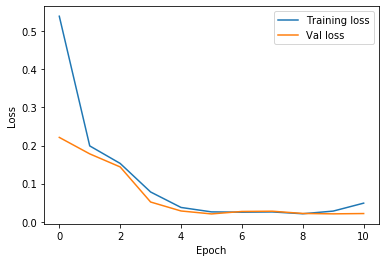

In [8]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Training loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
#   plt.ylim([0,1.1])
  plt.legend()
  plt.show()
plot_history(history)

### Load trained model 

In [8]:
# Load saved model
newmodel = keras.models.load_model('tf_model_CNN_location.h5')

### Sanity check of predictions on test set 

In [9]:
predictions = model.predict(test_dataset)

k = 123
predictions[k]

array([9.9673212e-01, 1.3416268e-06, 1.3002798e-06, 3.1064565e-03,
       4.9929499e-10, 4.9434918e-11, 4.3644901e-05, 8.8966328e-05,
       2.6276235e-05], dtype=float32)

In [10]:
model.predict(np.expand_dims(test_dataset.iloc[0], axis=0))

array([[9.9620879e-01, 2.4796564e-06, 1.3492887e-06, 3.3610840e-03,
        4.0334827e-10, 1.8006357e-11, 4.9740014e-05, 3.5814688e-04,
        1.8410232e-05]], dtype=float32)

In [11]:
# Location of highest prediction
np.argmax(predictions[0])

0

In [12]:
# Correct label in test set
test_labels.iloc[0]

0.0